In [1]:

import os, random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


**Este script entrena una red neuronal MobilenetV2 para detectar si una imagen tiene cruz o no**

INPUT: imagenes de cruces e imagenes sin cruces (ya seleccionadas). Carpetas: _CROSSED_ y _UNCROSSED_

OUTPUT: modelo MobilenetV2 entrenado

Entreno la red...

In [ ]:
# --- PARAMETERS ---
BATCH_SIZE = 32
IMG_SIZE = 64  # or 128, 96, etc
EPOCHS = 30
DATA_DIR = "entrenamiento"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# --- PARAMETERS ---
BATCH_SIZE = 32
IMG_SIZE = 64  # or 128, 96, etc
EPOCHS = 30
DATA_DIR = "entrenamiento"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- DATA TRANSFORMS ---
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# --- DATASETS & LOADERS ---
train_dataset = datasets.ImageFolder(
    root=DATA_DIR,
    transform=train_transform
)
val_dataset = datasets.ImageFolder(
    root=DATA_DIR,
    transform=val_transform
)

# Split train/val (80/20)
n_total = len(train_dataset)
n_val = int(0.2 * n_total)
n_train = n_total - n_val
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [n_train, n_val])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- MODEL ---
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 1)  # Binary classification
model = model.to(DEVICE)

# --- LOSS & OPTIMIZER ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- TRAIN LOOP ---
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += imgs.size(0)
    return running_loss / total, correct / total

def eval_model(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE).float().unsqueeze(1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels.int()).sum().item()
            total += imgs.size(0)
    return running_loss / total, correct / total

# --- TRAINING ---
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = eval_model(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.3f}")

# --- SAVE MODEL ---
torch.save(model.state_dict(), "cell_cross_classifier.pt")
print("Model saved as cell_cross_classifier.pt")

# --- OPTIONAL: INFERENCE FUNCTION ---
def predict_image(path, model, device=DEVICE):
    img = torchvision.io.read_image(path)
    img = transforms.functional.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.float() / 255.0
    img = img.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(img)
        prob = torch.sigmoid(out).cpu().item()
    return "cross" if prob > 0.5 else "no_cross", prob

/home/federico/miniconda3/envs/fedenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/federico/miniconda3/envs/fedenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30 | Train Loss: 0.1033 Acc: 0.964 | Val Loss: 0.0423 Acc: 0.991
Epoch 2/30 | Train Loss: 0.0627 Acc: 0.983 | Val Loss: 0.0999 Acc: 0.956
Epoch 3/30 | Train Loss: 0.0376 Acc: 0.991 | Val Loss: 0.0190 Acc: 0.992
Epoch 4/30 | Train Loss: 0.0232 Acc: 0.994 | Val Loss: 0.0106 Acc: 0.997
Epoch 5/30 | Train Loss: 0.0128 Acc: 0.995 | Val Loss: 0.0168 Acc: 0.995
Epoch 6/30 | Train Loss: 0.0062 Acc: 0.998 | Val Loss: 0.0114 Acc: 0.996
Epoch 7/30 | Train Loss: 0.0145 Acc: 0.997 | Val Loss: 0.0117 Acc: 0.993
Epoch 8/30 | Train Loss: 0.0155 Acc: 0.996 | Val Loss: 0.0211 Acc: 0.997
Epoch 9/30 | Train Loss: 0.0187 Acc: 0.993 | Val Loss: 0.0103 Acc: 0.996
Epoch 10/30 | Train Loss: 0.0204 Acc: 0.995 | Val Loss: 0.0086 Acc: 0.997
Epoch 11/30 | Train Loss: 0.0085 Acc: 0.997 | Val Loss: 0.0154 Acc: 0.995
Epoch 12/30 | Train Loss: 0.0049 Acc: 0.999 | Val Loss: 0.0257 Acc: 0.995
Epoch 13/30 | Train Loss: 0.0136 Acc: 0.997 | Val Loss: 0.0104 Acc: 0.996
Epoch 14/30 | Train Loss: 0.0036 Acc: 0.999 | V

Armo una matriz de confusion...

Mapeo de clases: {'0-CROSSED': 0, '0-UNCROSSED': 1}


/home/federico/miniconda3/envs/fedenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/federico/miniconda3/envs/fedenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Exactitud (accuracy): 0.9988
Classification report:
               precision    recall  f1-score   support

   0-CROSSED      0.997     0.997     0.997       399
 0-UNCROSSED      0.999     0.999     0.999      1251

    accuracy                          0.999      1650
   macro avg      0.998     0.998     0.998      1650
weighted avg      0.999     0.999     0.999      1650

Matriz de confusión (abs):
 [[ 398    1]
 [   1 1250]]


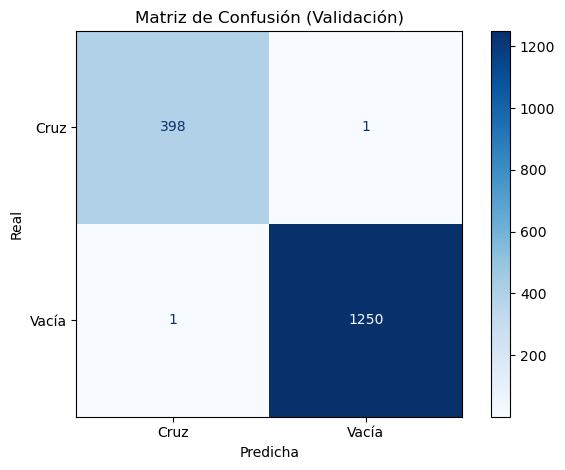

In [10]:
import os, numpy as np, torch, matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- PARAMETERS ---
BATCH_SIZE = 32
IMG_SIZE   = 64
VAL_DIR    = "validacion"
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
THRESH     = 0.5  # umbral para convertir probabilidad a clase
CKPT_PATH  = "cell_cross_classifier.pt"

# --- TRANSFORMS (coherentes con tu entrenamiento original) ---
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# --- LOAD VALIDATION DATASET ---
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transform)
val_loader  = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Mapeo de clases (orden alfabético). Ej: {'cross':0, 'no_cross':1}
print("Mapeo de clases:", val_dataset.class_to_idx)
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}
class_names  = [idx_to_class[i] for i in range(len(idx_to_class))]  # [clase_0, clase_1]

# --- LOAD MODEL ---
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, 1)
state = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE)
model.eval()

# --- EVALUATE ---
y_true, y_prob = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        logits = model(imgs)                      # (B,1)
        probs  = torch.sigmoid(logits).squeeze(1) # ≈ P(clase==1)
        y_prob.extend(probs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true).astype(int)
y_prob = np.array(y_prob)
y_pred = (y_prob > THRESH).astype(int)

# --- MÉTRICAS CLAVE ---
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
acc = (tp + tn) / cm.sum()
print(f"Exactitud (accuracy): {acc:.4f}")

report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
print("Classification report:\n", report)

print("Matriz de confusión (abs):\n", cm)

# --- PLOT 1: Matriz de confusión (absoluta) con etiquetas personalizadas opcionales ---
custom_labels = ["Cruz", "Vacía"]  # opcional; si preferís los nombres originales usa class_names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusión (Validación)")
plt.xlabel("Predicha"); plt.ylabel("Real")
plt.tight_layout()
plt.show()



Uso la red para identificar cruces en una imagen random

Procesando carpeta: sample115


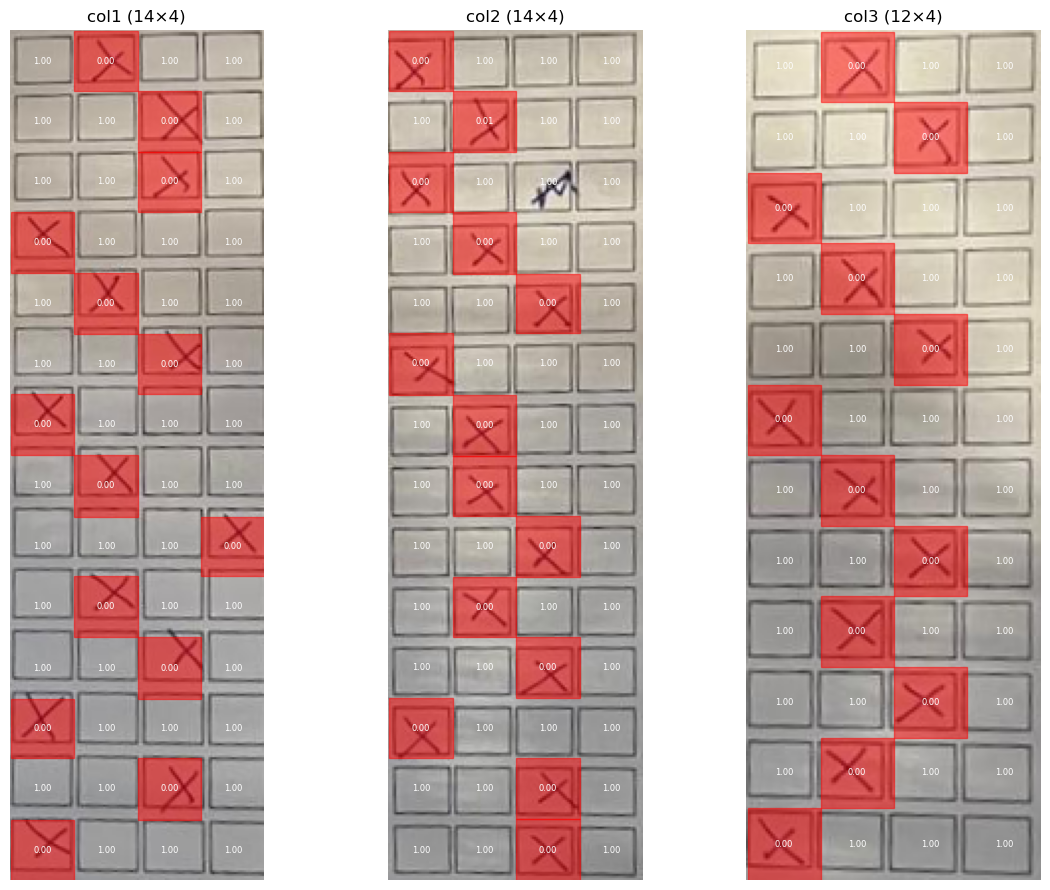

In [51]:
# — configuración —
CROPS_DIR = "crops_prueba"
MODEL_PATH = "cell_cross_classifier.pt"
IMG_SIZE   = 64
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# filas×columnas por clase
grid_specs = {
    "col1": (14, 4),
    "col2": (14, 4),
    "col3": (12, 4),
}

# cargo modelo
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, 1)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

# pipeline de preprocesado
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# elijo carpeta al azar
folders = [d for d in os.listdir(CROPS_DIR) 
           if os.path.isdir(os.path.join(CROPS_DIR, d))]
folder = random.choice(folders)
folder_path = os.path.join(CROPS_DIR, folder)
print("Procesando carpeta:", folder)

# qué grids están presentes
grids = [name for name in grid_specs
         if os.path.exists(os.path.join(folder_path, f"{name}.png"))]

# preparo figura
fig, axes = plt.subplots(1, len(grids), figsize=(4*len(grids), 9))
if len(grids) == 1:
    axes = [axes]

for ax, cls_name in zip(axes, grids):
    rows, cols = grid_specs[cls_name]
    img_path = os.path.join(folder_path, f"{cls_name}.png")
    bgr = cv2.imread(img_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = rgb.shape
    cell_h, cell_w = h/rows, w/cols

    ax.imshow(rgb)
    ax.set_title(f"{cls_name} ({rows}×{cols})")
    ax.axis("off")

    # recorro cada casillero
    for i in range(rows):
        for j in range(cols):
            y1, y2 = int(i*cell_h), int((i+1)*cell_h)
            x1, x2 = int(j*cell_w), int((j+1)*cell_w)
            cell = rgb[y1:y2, x1:x2]

            # inferencia
            inp = preprocess(cell).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                out = model(inp)
                prob = torch.sigmoid(out).item()

            # pinto la probabilidad siempre
            ax.text(
                x1 + (x2-x1)/2,
                y1 + (y2-y1)/2,
                f"{prob:.2f}",
                color='white', fontsize=6,
                ha='center', va='center'
            )

            # decido overlay según prob
            if prob < 0.10:
                color, alpha = 'red', 0.5    # ahora rojo = no-cross
            elif prob <= 0.90:
                color, alpha = 'yellow', 0.5 # sigue amarillo = incierto
            else:
                color = None                 # prob >0.90: nada

            if color:
                rect = plt.Rectangle(
                    (x1, y1), x2-x1, y2-y1,
                    color=color, alpha=alpha
                )
                ax.add_patch(rect)

plt.tight_layout()
plt.show()

Graficos de evaluacion

Registrar métricas por época (loss y accuracy)

In [9]:
import pandas as pd
import os

history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = eval_model(model, val_loader, criterion)

    history["epoch"].append(epoch + 1)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.3f}")

# Guardar historial
os.makedirs("images", exist_ok=True)
pd.DataFrame(history).to_csv("history_mobilenet.csv", index=False)


Epoch 1/30 | Train Loss: 0.0121 Acc: 0.996 | Val Loss: 0.0133 Acc: 0.997
Epoch 2/30 | Train Loss: 0.0062 Acc: 0.998 | Val Loss: 0.0119 Acc: 0.999
Epoch 3/30 | Train Loss: 0.0047 Acc: 0.999 | Val Loss: 0.0120 Acc: 0.997
Epoch 4/30 | Train Loss: 0.0296 Acc: 0.992 | Val Loss: 0.0175 Acc: 0.996
Epoch 5/30 | Train Loss: 0.0118 Acc: 0.996 | Val Loss: 0.0148 Acc: 0.995
Epoch 6/30 | Train Loss: 0.0042 Acc: 0.999 | Val Loss: 0.0230 Acc: 0.993
Epoch 7/30 | Train Loss: 0.0066 Acc: 0.998 | Val Loss: 0.0151 Acc: 0.996
Epoch 8/30 | Train Loss: 0.0050 Acc: 0.997 | Val Loss: 0.0162 Acc: 0.996
Epoch 9/30 | Train Loss: 0.0030 Acc: 0.999 | Val Loss: 0.0155 Acc: 0.997
Epoch 10/30 | Train Loss: 0.0068 Acc: 0.998 | Val Loss: 0.0145 Acc: 0.997
Epoch 11/30 | Train Loss: 0.0021 Acc: 1.000 | Val Loss: 0.0125 Acc: 0.999
Epoch 12/30 | Train Loss: 0.0017 Acc: 1.000 | Val Loss: 0.0190 Acc: 0.996
Epoch 13/30 | Train Loss: 0.0175 Acc: 0.994 | Val Loss: 0.0385 Acc: 0.992
Epoch 14/30 | Train Loss: 0.0109 Acc: 0.997 | V

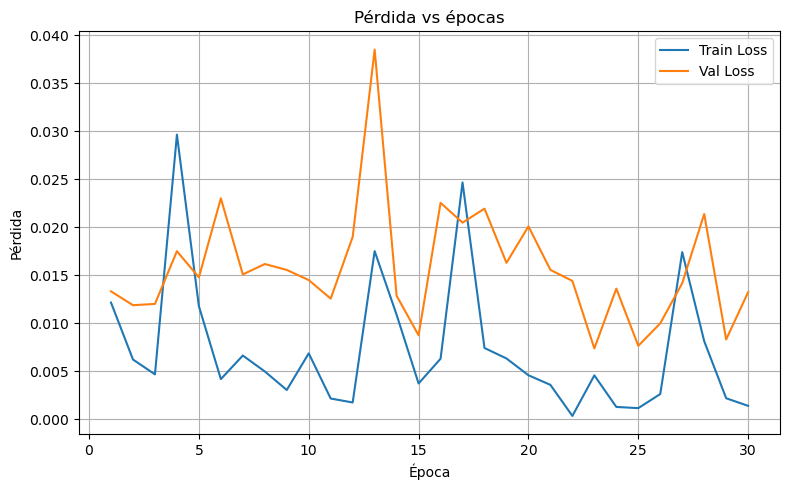

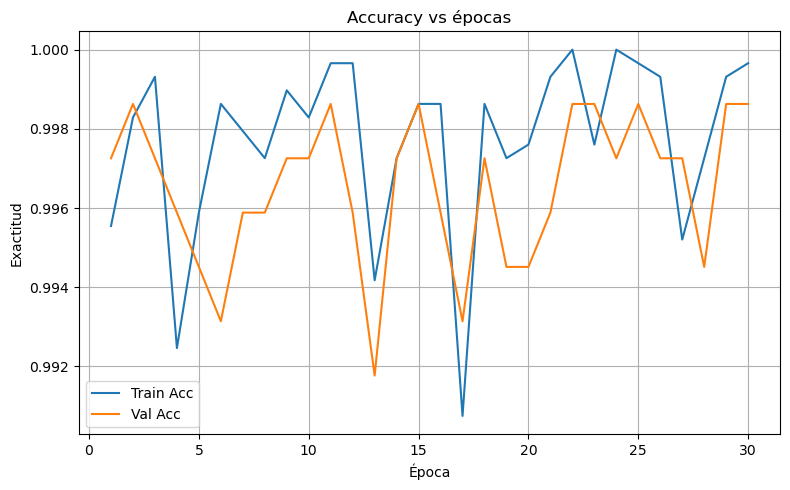

In [10]:
import matplotlib.pyplot as plt

dfh = pd.read_csv("history_mobilenet.csv")

plt.figure(figsize=(8,5))
plt.plot(dfh["epoch"], dfh["train_loss"], label="Train Loss")
plt.plot(dfh["epoch"], dfh["val_loss"],   label="Val Loss")
plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title("Pérdida vs épocas")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("images/loss_vs_epochs.png", dpi=200)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(dfh["epoch"], dfh["train_acc"], label="Train Acc")
plt.plot(dfh["epoch"], dfh["val_acc"],   label="Val Acc")
plt.xlabel("Época"); plt.ylabel("Exactitud"); plt.title("Accuracy vs épocas")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("images/acc_vs_epochs.png", dpi=200)
plt.show()


In [11]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, brier_score_loss
)
import matplotlib.pyplot as plt

def collect_logits_and_labels(model, loader, device=DEVICE):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device).float()
            logits = model(imgs).squeeze(1)  # (B,)
            all_logits.append(logits.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return np.concatenate(all_logits), np.concatenate(all_labels)

logits_val, y_true = collect_logits_and_labels(model, val_loader, DEVICE)
probs_val = 1/(1 + np.exp(-logits_val))  # sigmoide
y_pred_05 = (probs_val > 0.5).astype(int)  # umbral 0.5 por defecto

acc  = accuracy_score(y_true, y_pred_05)
prec = precision_score(y_true, y_pred_05, zero_division=0)
rec  = recall_score(y_true, y_pred_05, zero_division=0)
f1   = f1_score(y_true, y_pred_05, zero_division=0)

print(f"Val Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

cm = confusion_matrix(y_true, y_pred_05)
print("Confusion Matrix:\n", cm)


Val Accuracy: 0.9986 | Precision: 1.0000 | Recall: 0.9981 | F1: 0.9990
Confusion Matrix:
 [[206   0]
 [  1 522]]


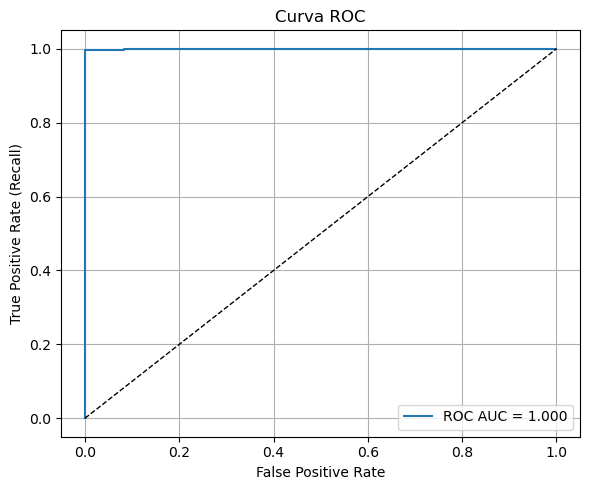

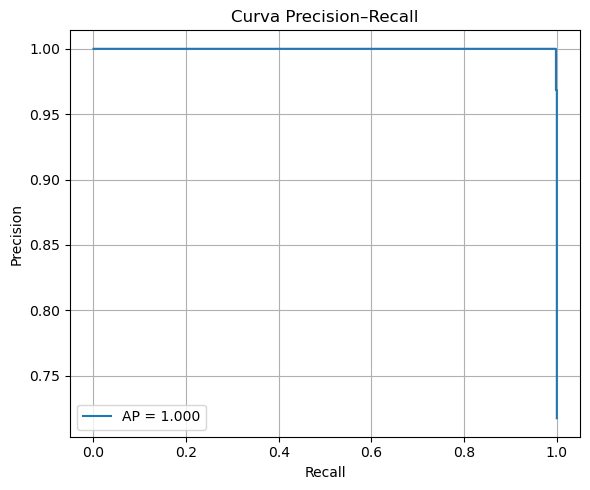

In [12]:
# ROC
fpr, tpr, _ = roc_curve(y_true, probs_val)
auc_roc = roc_auc_score(y_true, probs_val)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc_roc:.3f}")
plt.plot([0,1],[0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.savefig("images/roc_curve.png", dpi=200); plt.show()

# Precision–Recall
prec_curve, rec_curve, thr = precision_recall_curve(y_true, probs_val)
ap = average_precision_score(y_true, probs_val)

plt.figure(figsize=(6,5))
plt.plot(rec_curve, prec_curve, label=f"AP = {ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Curva Precision–Recall")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("images/pr_curve.png", dpi=200); plt.show()


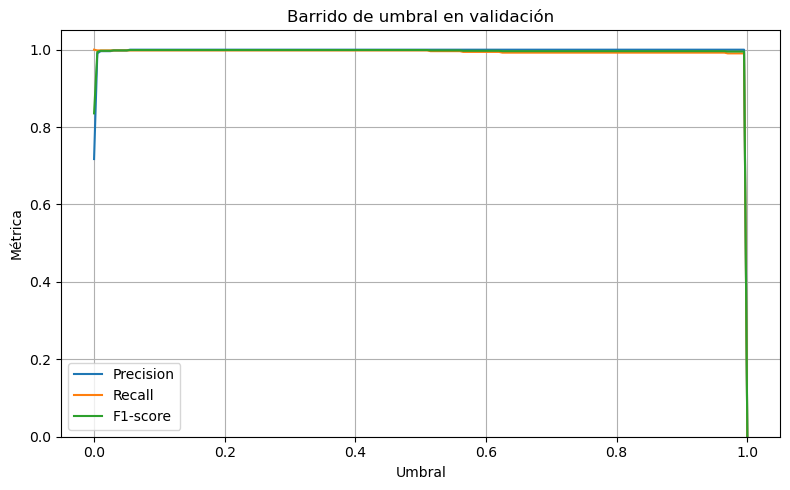

Umbral óptimo (por F1): 0.055


In [13]:
ths = np.linspace(0.0, 1.0, 201)
f1s, precs, recs = [], [], []

for t in ths:
    y_pred_t = (probs_val > t).astype(int)
    f1s.append(f1_score(y_true, y_pred_t, zero_division=0))
    precs.append(precision_score(y_true, y_pred_t, zero_division=0))
    recs.append(recall_score(y_true, y_pred_t, zero_division=0))

plt.figure(figsize=(8,5))
plt.plot(ths, precs, label="Precision")
plt.plot(ths, recs, label="Recall")
plt.plot(ths, f1s, label="F1-score")
plt.xlabel("Umbral"); plt.ylabel("Métrica"); plt.ylim(0,1.05)
plt.title("Barrido de umbral en validación")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("images/threshold_sweep.png", dpi=200); plt.show()

t_opt = ths[int(np.argmax(f1s))]
print(f"Umbral óptimo (por F1): {t_opt:.3f}")


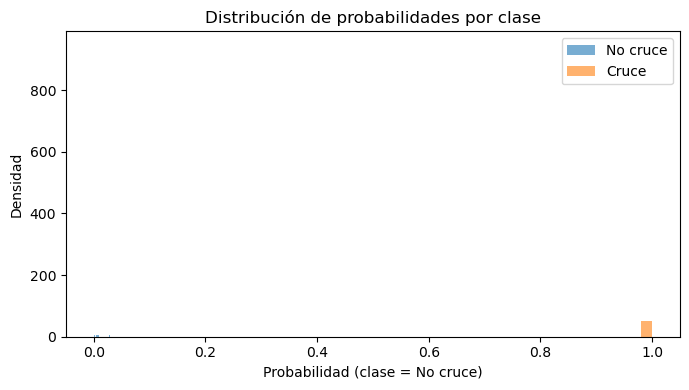

In [14]:
plt.figure(figsize=(7,4))
plt.hist(probs_val[y_true==0], bins=50, alpha=0.6, label="No cruce", density=True)
plt.hist(probs_val[y_true==1], bins=50, alpha=0.6, label="Cruce", density=True)
plt.xlabel("Probabilidad (clase = No cruce)"); plt.ylabel("Densidad")
plt.title("Distribución de probabilidades por clase")
plt.legend(); plt.tight_layout()
plt.savefig("images/hist_probs.png", dpi=200); plt.show()


Brier score: 0.0022


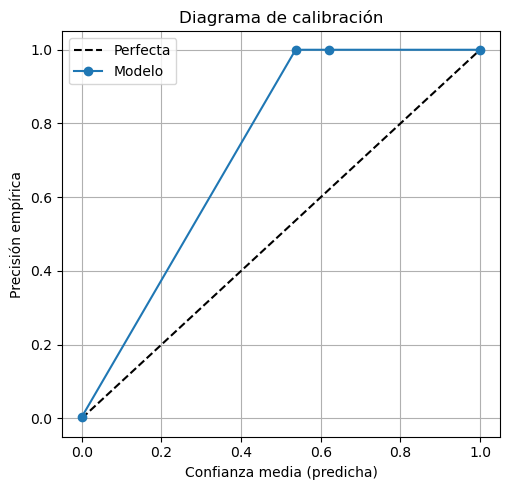

In [15]:
def reliability_diagram(y_true, probs, n_bins=10, fname="images/reliability.png"):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    binids = np.digitize(probs, bins) - 1
    accs, confs = [], []
    for b in range(n_bins):
        idx = binids == b
        if np.sum(idx) > 0:
            accs.append(np.mean(y_true[idx]))
            confs.append(np.mean(probs[idx]))
        else:
            accs.append(np.nan)
            confs.append((bins[b]+bins[b+1])/2)
    accs, confs = np.array(accs), np.array(confs)
    mask = ~np.isnan(accs)

    plt.figure(figsize=(5.2,5))
    plt.plot([0,1],[0,1], 'k--', label="Perfecta")
    plt.plot(confs[mask], accs[mask], marker="o", label="Modelo")
    plt.xlabel("Confianza media (predicha)"); plt.ylabel("Precisión empírica")
    plt.title("Diagrama de calibración")
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig(fname, dpi=200); plt.show()

# Brier score (cuanto menor, mejor calibración)
bs = brier_score_loss(y_true, probs_val)
print(f"Brier score: {bs:.4f}")
reliability_diagram(y_true, probs_val)


In [ ]:
with open("mobilenet_val_report.txt", "w") as f:
    f.write(f"Val Accuracy: {acc:.4f}\n")
    f.write(f"Val Precision: {prec:.4f}\n")
    f.write(f"Val Recall: {rec:.4f}\n")
    f.write(f"Val F1: {f1:.4f}\n")
    f.write(f"ROC AUC: {auc_roc:.4f}\n")
    f.write(f"Average Precision (PR AUC): {ap:.4f}\n")
    f.write(f"Brier score: {bs:.4f}\n")
    f.write(f"Best threshold (F1): {t_opt:.3f}\n")
print("Reporte guardado en mobilenet_val_report.txt")
